
# How to use SKADA

This is a short example to get started with SKADA and perform domain adaptation
on a simple dataset. It illustrates the API choice specific to DA.


In [1]:
# Author: Remi Flamary
#
# License: BSD 3-Clause
# sphinx_gallery_thumbnail_number = 1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from skada import (
    CORAL,
    CORALAdapter,
    GaussianReweightAdapter,
    PerDomain,
    SelectSource,
    SelectSourceTarget,
    make_da_pipeline,
    source_target_split,
)
from skada.datasets import make_shifted_datasets
from skada.metrics import PredictionEntropyScorer
from skada.model_selection import SourceTargetShuffleSplit

2025-03-09 20:16:13.978250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741547773.998570 1673772 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741547774.004601 1673772 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## DA dataset

We generate a simple 2D DA dataset. Note that DA datasets provided by SKADA
are organized as follows:

* :code:`X` is the input data, including the source and the target samples
* :code:`y` is the output data to be predicted (labels on target samples are not
  used when fitting the DA estimator)
* :code:`sample_domain` encodes the domain of each sample (integer >=0 for
  source and <0 for target)



Text(0.5, 1.0, 'Target data')

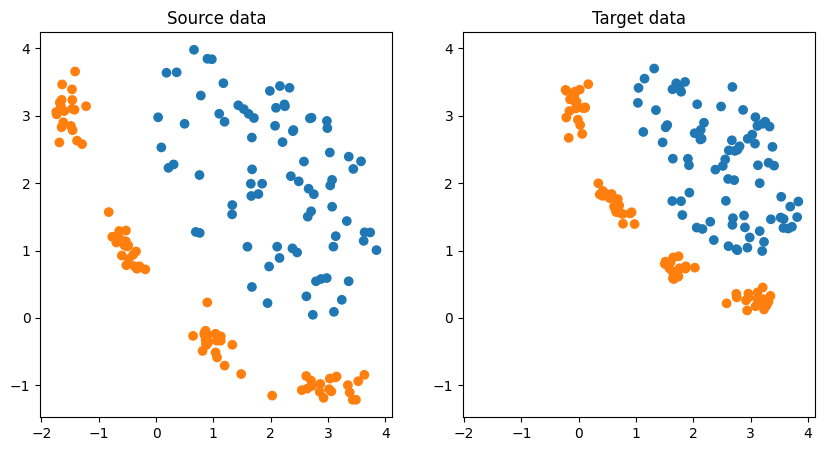

In [3]:
# Get DA dataset
X, y, sample_domain = make_shifted_datasets(
    20, 20, shift="concept_drift", random_state=42
)

# split source and target for visualization
Xs, Xt, ys, yt = source_target_split(X, y, sample_domain=sample_domain)
sample_domain_s = np.ones(Xs.shape[0])
sample_domain_t = -np.ones(Xt.shape[0]) * 2

# plot data
plt.figure(1, (10, 5))

plt.subplot(1, 2, 1)
plt.scatter(Xs[:, 0], Xs[:, 1], c=ys, cmap="tab10", vmax=9, label="Source")
plt.title("Source data")
ax = plt.axis()

plt.subplot(1, 2, 2)
plt.scatter(Xt[:, 0], Xt[:, 1], c=yt, cmap="tab10", vmax=9, label="Target")
plt.axis(ax)
plt.title("Target data")

## DA Classifier estimator

SKADA estimators are used like scikit-learn estimators. The only difference is
that the :code:`sample_domain` array must be passed by name when fitting the
estimator.



In [4]:
# create a DA estimator
clf = CORAL()

# train on all data
clf.fit(X, y, sample_domain=sample_domain)

# estimator is designed to predict on target by default
yt_pred = clf.predict(Xt)

# accuracy on source and target
print("Accuracy on source:", clf.score(Xs, ys))
print("Accuracy on target:", clf.score(Xt, yt))

Accuracy on source: 0.84375
Accuracy on target: 1.0


## DA estimator in a pipeline




In [5]:
# SKADA estimators can be used as the final estimator of a scikit-learn pipeline.
# Again, the only difference is that the :code:`sample_domain` array must be passed
# by name during in fit.


# create a DA pipeline
pipe = make_pipeline(StandardScaler(), CORAL(base_estimator=SVC()))
pipe.fit(X, y, sample_domain=sample_domain)

print("Accuracy on target:", pipe.score(Xt, yt))

Accuracy on target: 1.0


## DA Adapter pipeline

Several SKADA estimators include a data adapter that transforms the input data
so that a scikit-learn estimator can be used. For those methods, SKADA
provides a :code:`Adapter` class that can be used in a DA pipeline from
:code:`make_da_pipeline`.

Here is an example with the CORAL and GaussianReweight adapters.

.. WARNING::



In [ ]:
#   Note that as illustrated below for reweighting adapters, one needs a
#   subsequent estimator that takes :code:`sample_weight` as an input parameter.
#   This can be done using the :code:`set_fit_request` method of the estimator
#   by calling :code:`.set_fit_request(sample_weight=True)`.
#   If the estimator (for pipeline or DA estimator) does not
#   require sample weights, the DA pipeline will raise an error.


# create a DA pipeline with CORAL adapter
pipe = make_da_pipeline(StandardScaler(), CORALAdapter(), SVC())
pipe.fit(X, y, sample_domain=sample_domain)

print("Accuracy on target:", pipe.score(Xt, yt))

# create a DA pipeline with GaussianReweight adapter (does not work well on
# concept drift).
pipe = make_da_pipeline(
    StandardScaler(),
    GaussianReweightAdapter(),
    LogisticRegression().set_fit_request(sample_weight=True),
)
pipe.fit(X, y, sample_domain=sample_domain)

print("Accuracy on target:", pipe.score(Xt, yt))

## DA estimators with score cross-validation

DA estimators are compatible with scikit-learn cross-validation functions.
Note that the :code:`sample_domain` array must be passed in the :code:`params`
dictionary of the :code:`cross_val_score` function.



In [ ]:
# splitter for cross-validation of score
cv = SourceTargetShuffleSplit(random_state=0)

# DA scorer not using target labels (not available in DA)
scorer = PredictionEntropyScorer()

clf = CORAL(SVC(probability=True))  # needs probability for entropy score

# cross-validation
scores = cross_val_score(
    clf, X, y, params={"sample_domain": sample_domain}, cv=cv, scoring=scorer
)

print(f"Entropy score: {scores.mean():1.2f} (+-{scores.std():1.2f})")

## DA estimator with grid search

DA estimators are also compatible with scikit-learn grid search functions.
Note that the :code:`sample_domain` array must be passed in the :code:`fit`
method of the grid search.



In [ ]:
reg_coral = [0.1, 0.5, 1, "auto"]

clf = make_da_pipeline(StandardScaler(), CORALAdapter(), SVC(probability=True))

# grid search
grid_search = GridSearchCV(
    estimator=clf,
    param_grid={"coraladapter__reg": reg_coral},
    cv=SourceTargetShuffleSplit(random_state=0),
    scoring=PredictionEntropyScorer(),
)

grid_search.fit(X, y, sample_domain=sample_domain)

print("Best regularization parameter:", grid_search.best_params_["coraladapter__reg"])
print("Accuracy on target:", np.mean(grid_search.predict(Xt) == yt))

## Advanced DA pipeline

The DA pipeline can be used with any estimator and any adapter. But more
importantly all estimators in the pipeline are automatically wrapped in what
we call in skada a `Selector`. The selector is a wrapper that allows you to
choose which data is passed during fit and predict/transform.

In the following example, one StandardScaler is trained per domain. Then
a single SVC is trained on source data only. When predicting on target data the
pipeline will automatically use the StandardScaler trained on target and the SVC
trained on source.



In [ ]:
# create a DA pipeline with SelectSourceTarget estimators

pipe = make_da_pipeline(
    SelectSourceTarget(StandardScaler()),
    SelectSource(SVC()),
)

pipe.fit(X, y, sample_domain=sample_domain)

print("Accuracy on source:", pipe.score(Xs, ys, sample_domain=sample_domain_s))
print("Accuracy on target:", pipe.score(Xt, yt))  # target by default

Similarly one can use the PerDomain selector to train a different estimator
per domain. This allows to handle multiple source and target domains. In this
case :code:`sample_domain` must be provided to fit and predict/transform.



In [ ]:
pipe = make_da_pipeline(
    PerDomain(StandardScaler()),
    SelectSource(SVC()),
)

pipe.fit(X, y, sample_domain=sample_domain)

print("Accuracy on all data:", pipe.score(X, y, sample_domain=sample_domain))

One can use a default selector on the whole pipeline which allows for
instance to train the whole pipeline only on the source data as follows:



In [ ]:
pipe_train_on_source = make_da_pipeline(
    StandardScaler(),
    SVC(),
    default_selector=SelectSource,
)

pipe_train_on_source.fit(X, y, sample_domain=sample_domain)
print("Accuracy on source:", pipe_train_on_source.score(Xs, ys))
print("Accuracy on target:", pipe_train_on_source.score(Xt, yt))

One can also use a default selector on the whole pipeline but overwrite it for
the last estimator. In the example below a :code:`StandardScaler` and a
:code:`PCA` are estimated per domain but the final SVC is trained on source data only.



In [ ]:
pipe_perdomain = make_da_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    SelectSource(SVC()),
    default_selector=SelectSourceTarget,
)

pipe_perdomain.fit(X, y, sample_domain=sample_domain)
print(
    "Accuracy on source:", pipe_perdomain.score(Xs, ys, sample_domain=sample_domain_s)
)
print(
    "Accuracy on target:", pipe_perdomain.score(Xt, yt, sample_domain=sample_domain_t)
)